In [1]:
from obspy.core.trace import Trace

from bokeh.io import output_notebook, show
from bokeh.layouts import column
from bokeh.plotting import figure

import numpy as np
from scipy import signal

output_notebook()

%matplotlib inline

Loading BokehJS ...

In [2]:
### sr = 250. # Hertz

rnum = 0.000001
signal_000 = np.concatenate((np.random.uniform(-rnum, rnum, size=1024+8383), np.array([2.0]), np.random.uniform(-rnum, rnum, size=8000)))
signal_669 = np.concatenate((np.random.uniform(-rnum, rnum, size=1024+10000), np.array([1.0]), np.random.uniform(-rnum, rnum, size=2767), 
                             np.array([-1.0]), np.random.uniform(-rnum, rnum, size=20000)))


#signal_000 = np.concatenate((np.zeros(1024+8383), np.array([2.0]), np.zeros(8000)))
#signal_669 = np.concatenate((np.zeros(1024+10000), np.array([1.0]), np.zeros(2767), np.array([-1.0]), np.zeros(20000)))

In [3]:
sr = 250.
s_000 = Trace(signal_000, header={'delta':1/sr})
s_669 = Trace(signal_669, header={'delta':1/sr})

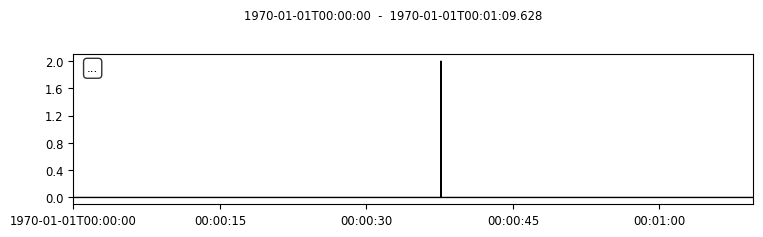

In [4]:
s_000.plot()

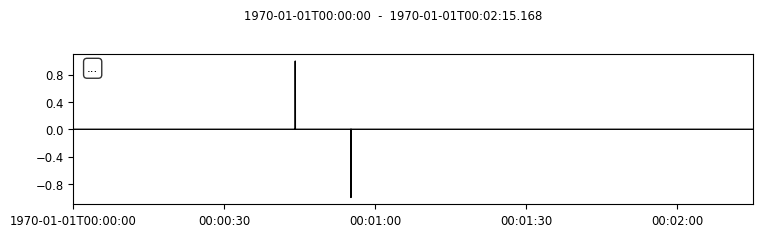

In [5]:
s_669.plot()

In [6]:
def write_to_sac():
    s_000.write('s.Z.000.sac', type='SAC')
    s_000.write('s.N.000.sac', type='SAC')
    s_000.write('s.E.000.sac', type='SAC')

    s_669.write('s.Z.669.sac', type='SAC')
    s_669.write('s.N.669.sac', type='SAC')
    s_669.write('s.E.669.sac', type='SAC')

#write_to_sac()

### TRANSFER FUNCTION USING PERIODOGRAM/WELCH

In [7]:
from numpy.fft import rfft, irfft, fft, ifft

In [8]:
#signal_000 = np.concatenate((np.zeros(9999), np.array([2.0]), np.zeros(10000)))
#signal_669 = np.concatenate((np.zeros(8999), np.array([1.0]), np.zeros(1999), np.array([-1.0]), np.zeros(9000)))

p = figure(plot_width=800, plot_height=400)
p.line(np.linspace(0, len(signal_000)/sr,  len(signal_000)), signal_000, line_width=2, line_color='red', legend="000")
p.line(np.linspace(0, len(signal_669)/sr,  len(signal_669)), signal_669, line_width=2, line_color='blue', line_alpha=0.5, legend="669")
show(p)


In [9]:
#f_000, Pxx_000 = signal.welch(signal_000, sr, nperseg=len(signal_000), scaling="spectrum")
#f_669, Pxx_669 = signal.welch(signal_669, sr, nperseg=len(signal_669), scaling="spectrum")

f_000, Pxx_000 = signal.welch(signal_000, sr, nperseg=0.1*len(signal_000), scaling="spectrum")
f_669, Pxx_669 = signal.welch(signal_669, sr, nperseg=0.1*len(signal_669), scaling="spectrum")

p = figure(plot_width=800, plot_height=400, y_axis_type="log", x_axis_type="log")
p.line(f_000, np.sqrt(Pxx_000), line_width=2, line_color='red', legend="000")
p.line(f_669, np.sqrt(Pxx_669), line_width=2, line_color='blue', legend="669")
show(p)

In [10]:
# both vectors must contain the same frequencies and dimensions
new_Pxx_000 = np.interp(f_669, f_000, Pxx_000)
#trans_func = np.sqrt(new_Pxx_000)/np.sqrt(Pxx_669)
trans_func = new_Pxx_000.real/Pxx_669.real
p = figure(plot_width=800, plot_height=400, y_axis_type="log", x_axis_type="log")
p.line(f_669, trans_func, line_width=2, line_color='blue', legend="TF")
show(p)

In [11]:
### fft_000 = rfft(signal_000)

fft_669 = rfft(signal_669)
new_f_699 = np.linspace(0, sr/2, len(fft_669))
new_trans_func = np.interp(new_f_699, f_669, trans_func)
ifft_669 = irfft(fft_669*new_trans_func)

p = figure(plot_width=800, plot_height=400)
p.line(range(len(ifft_669)), np.real(ifft_669), line_width=2, line_color='blue', legend="669")
show(p)

### TRANSFER FUNCTION USING SPEC

In [12]:
f_000 = np.linspace(0, sr, len(signal_000))
f_669 = np.linspace(0, sr, len(signal_669))

fft_000 = fft(signal_000, norm=None)
fft_669 = fft(signal_669, norm=None)

len(f_000), len(fft_000), len(signal_000), f_000[-1]

p = figure(plot_width=800, plot_height=400, y_axis_type="log", x_axis_type="log")
p.line(f_000, np.abs(fft_000), line_width=2, line_color='red', legend="000")
p.line(f_669, np.abs(fft_669), line_width=2, line_color='blue', legend="669")
show(p)

In [13]:
# both vectors must contain the same frequencies and dimensions
new_fft_000 = np.interp(f_669, f_000, fft_000)
#trans_func = np.sqrt(new_fft_000)/np.sqrt(fft_669)
trans_func = new_fft_000.real/fft_669.real
p = figure(plot_width=800, plot_height=400, y_axis_type="log", x_axis_type="log")
p.line(f_669, np.abs(trans_func), line_width=2, line_color='blue', legend="TF")
show(p)

In [14]:
fft_669 = fft(signal_669)
new_f_699 = np.linspace(0, sr/2, len(fft_669))
new_trans_func = np.interp(new_f_699, f_669, trans_func)
ifft_669 = ifft(fft_669*new_trans_func)

p = figure(plot_width=800, plot_height=400, y_axis_type="log")
p.line(range(len(ifft_669)), np.abs(ifft_669), line_width=1, line_color='blue', legend="669")
show(p)

### create tests of noise seismograms

In [15]:
def gen_noisy():
    sr = 250;
    T1=10; L1 = T1*sr; A1=1; # noise
    T2=10; L2 = T2*sr; A2=20; # p-wavesudo
    T3=50; L3 = T3*sr; A3=500; # s-wave
    N1 = A1*(np.random.rand(L1,1)-0.5); P1 = A2*(np.random.rand(L2,1)-0.5); S1 = A3*(np.random.rand(L3,1)-0.5);
    synth_000 = np.concatenate((N1, P1, S1), axis=0)
    synth_000 = synth_000.reshape(len(synth_000))

    T1=10; L1 = T1*sr; A1=1; # noise
    T2=10; L2 = T2*sr; A2=10; # p-wave
    T3=70; L3 = T3*sr; A3=50; # s-wave
    N1 = A1*(np.random.rand(L1,1)-0.5); P1 = A2*(np.random.rand(L2,1)-0.5); S1 = A3*(np.random.rand(L3,1)-0.5);
    synth_669 = np.concatenate((N1, P1, S1), axis=0)
    synth_669 = synth_669.reshape(len(synth_669))
    
    s_000 = Trace(synth_000, header={'delta':1/sr})
    s_669 = Trace(synth_669, header={'delta':1/sr})
    return s_000, s_669

def write_to_sac(s_000, s_669, n):
    s_000.write('noisy{:02d}.Z.000.sac'.format(n), type='SAC')
    s_000.write('noisy{:02d}.N.000.sac'.format(n), type='SAC')
    s_000.write('noisy{:02d}.E.000.sac'.format(n), type='SAC')

    s_669.write('noisy{:02d}.Z.669.sac'.format(n), type='SAC')
    s_669.write('noisy{:02d}.N.669.sac'.format(n), type='SAC')
    
    s_669.write('noisy{:02d}.E.669.sac'.format(n), type='SAC')


In [16]:
for n in range(100):
    s_000, s_669 = gen_noisy()
    write_to_sac(s_000, s_669, n)
    

### 

In [ ]:
sr = 250;
T1=10; L1 = T1*sr; A1=1; # noise
T2=10; L2 = T2*sr; A2=20; # p-wavesudo
T3=50; L3 = T3*sr; A3=100; # s-wave
N1 = A1*(np.random.rand(L1,1)-0.5); P1 = A2*(np.random.rand(L2,1)-0.5); S1 = A3*(np.random.rand(L3,1)-0.5);
synth_000 = np.concatenate((N1, P1, S1), axis=0)
synth_000 = synth_000.reshape(len(synth_000))

T1=10; L1 = T1*sr; A1=1; # noise""""""""""""""
T2=10; L2 = T2*sr; A2=10; # p-wave
T3=70; L3 = T3*sr; A3=50; # s-wave
N1 = A1*(np.random.rand(L1,1)-0.5); P1 = A2*(np.random.rand(L2,1)-0.5); S1 = A3*(np.random.rand(L3,1)-0.5);
synth_669 = np.concatenate((N1, P1, S1), axis=0)
synth_669 = synth_669.reshape(len(synth_669))
    
s_000 = Trace(synth_000, header={'delta':1/sr})
s_669 = Trace(synth_669, header={'delta':1/sr})

p1 = figure(plot_width=800, plot_height=400)
p1.line(range(len(synth_000)), synth_000.data)

p2 = figure(plot_width=800, plot_height=400)
p2.line(range(len(synth_669)), synth_669.data, )


show(column(p1, p2))

### 